# Imports

In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ahmed Mustafa
[nltk_data]     Malik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Defining Tweet Class

In [8]:
class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

# Definining Methods for Data Loading and Cleaning

In [9]:
def cleanTweet(tweet):
    # print(tweet.content,"\n")
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub("@ [a-zA-Z0-9]+", '', tweet.content) # remove @mentions
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet.content) # remove hyperlinks
    tweet.content = re.sub(r'#', '', tweet.content) # remove hastags
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    # print(tweet.content)
    # print("============================================================================")
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one==True:
                if last_one==True or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one==True:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one==True:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if test_data==False else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
        return all_tweets

# Defining Methods for creating Embeddings

## Frequency Based Method

In [10]:
def frequency_based_embeddings(all_tweets):
    freqs = dict()
    for i in all_tweets:
        for word in i.content.split():
            pair = (word, i.sentiment)
            freqs[pair] = freqs.get(pair, 0) + 1
    all_positive_tweets = [i.content for i in all_tweets if i.sentiment=='positive']
    all_negative_tweets = [i.content for i in all_tweets if i.sentiment=='negative']
    all_neutral_tweets = [i.content for i in all_tweets if i.sentiment=='neutral']
    tweets = all_neutral_tweets + all_positive_tweets + all_negative_tweets
    X = np.empty((0,4))
    for i in tweets:
        neutral_words_freq = 0
        positive_words_freq = 0
        negative_words_freq = 0
        for word in i.split():
            neutral_words_freq += freqs.get((word,'neutral'),0)
            positive_words_freq += freqs.get((word,'positive'),0)
            negative_words_freq += freqs.get((word,'negative'),0)
        X = np.append(X, np.array([[1, neutral_words_freq, positive_words_freq, negative_words_freq]]), axis=0)
    Y = np.append(np.zeros(len(all_neutral_tweets)), np.ones(len(all_positive_tweets)))
    Y = np.append(Y, np.full(len(all_negative_tweets),2))
    return X,Y

# Defining Method for Showing Results

In [11]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['1','2','3']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plot_confusion_matrix(cnf_matrix)

# ===================================================

# Mission Control - Training

### Data Loading

In [12]:
all_tweets = readFile(r'data\train\train_14k_split_conll.txt')
all_tweets.extend(readFile(r'data\train\dev_3k_split_conll.txt'))
all_tweets.extend(readFile(r'data\train\train_conll.txt'))
all_tweets.extend(readFile(r'data\train\trial_conll.txt'))

### Creating File for Fast-Text 

In [13]:
with open('data/fast-text-data/data.train.txt', 'w', encoding="utf-8") as fp:
    for i in all_tweets:
        fp.write("__label__"+i.sentiment+" "+i.content+"\n")

### Model - Training

In [63]:
import fasttext
model = fasttext.train_supervised('data/fast-text-data/data.train.txt',epoch=50,wordNgrams=4)

# ===================================================

# Mission Control - Prediction

### Loading Prediction Data

In [64]:
actual_labels_dict = dict()
with open(r'data\test\test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        actual_labels_dict[line.strip().split(',')[0]] = line.strip().split(',')[1]
all_test_tweets = readFile(r'data\test\Hindi_test_unalbelled_conll_updated.txt',test_data=True)
for i in all_test_tweets:
    i.sentiment = actual_labels_dict[i.uid]

### Getting the Predictions

In [65]:
predictions = []
for i in all_test_tweets:
    predictions.append(model.predict(i.content))

### The Results

F1 Score:  0.6613814946947009



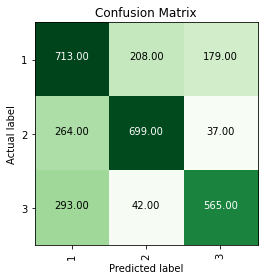

In [66]:
actual_num = []
for i in all_test_tweets:
    if i.sentiment == "neutral":
        actual_num.append(0)
    elif i.sentiment == "positive":
        actual_num.append(1)
    elif i.sentiment == "negative":
        actual_num.append(2)
predictions_num = []
for i in predictions:
    if i[0][0] == "__label__neutral":
        predictions_num.append(0)
    elif i[0][0] == "__label__positive":
        predictions_num.append(1)
    elif i[0][0] == "__label__negative":
        predictions_num.append(2)

show_results(actual_num, predictions_num)

# Analysing Incorrect Results

In [77]:
for i in range(len(actual_num)):
    if (actual_num[i]!=predictions_num[i]):
        print("Actual:",all_test_tweets[i].sentiment)
        print("Predicted:",predictions[i][0][0][9:])
        print(all_test_tweets[i].content)
        print("=====================================================================")

Actual: neutral
Predicted: positive
alloo pyaz tomat allah pak naam nazar aa pr aankhon samne allah pak nazar â € ¦ http co hbg 7zs0viy
Actual: negative
Predicted: neutral
tm dikha rhy asli auqaat wese btao tou ye propaganda kyu krta shahid masood
Actual: positive
Predicted: neutral
wah shandaar jabab
Actual: negative
Predicted: neutral
modi lehar kisano baras kehar tut haath pao road buri halato aasar â € ¦ http co 3ffap8y2gp
Actual: positive
Predicted: neutral
haan mai free wi-fi dunga free water sasti bijli doo â € ¦ http co d4uoicb562
Actual: negative
Predicted: neutral
log bara chootiya hy jhoot manker vote krdiya bcz govt foult terror bring 100 kg rdx kill 5â € ¦ http co dkmzdwqd 1c
Actual: negative
Predicted: neutral
banerj e time circumst ke change bada bewakuf â € ¦ http co gpit 7q9zjx
Actual: neutral
Predicted: positive
mafia bhaai engineers sirf love krte wo love marriage mai convert naaai
Actual: positive
Predicted: neutral
zinda hoon main tujhme tujhme rahunga zinda todke 

inko chatukarita fursat mile tabhi free ka kamma h pta muft rotiya â € ¦ http co cm4xzszfiw
Actual: negative
Predicted: neutral
cleavag foreign accent rakhne intellectu ho
Actual: positive
Predicted: neutral
offic modi hame bijli choola ham vote a apt analysi result 2019 gener â € ¦
Actual: negative
Predicted: neutral
she suspend sarkar ko logo ko badhawa dena agar janbujhkar kiya j â € ¦ http co igyallrugv
Actual: neutral
Predicted: positive
i the love club http co ghdspbqgiq
Actual: neutral
Predicted: positive
which best pair comment prabha trisha anushka tamamnnah kajalaggarwal http co gkmjuh 4cbj
Actual: negative
Predicted: neutral
rt jb kcuh rhta vikrant gupta batha dete bakcoodi â € ¦ http co ox15ccbxoq
Actual: negative
Predicted: neutral
km km aapke news channel bjp jeet sachchai samne lana jeet sirf sirf bema â € ¦ http co 4utxoy3rel
Actual: negative
Predicted: neutral
rana aur ladke ladki mater fhasaa kr person mater bhadass nikali kutto au â € ¦ http co zb1lthicbw
Actual: neg

Predicted: neutral
nh log attent seeker nh banna chahty embarasmnt
Actual: neutral
Predicted: negative
ye anti incumb h madam 70 saal desh haal kra h v kr daag â € ¦ http co abdgxsrwq 0
Actual: positive
Predicted: neutral
you mami ðÿ ¤ ª even though â € ™ food starbuck ðÿ ˜ ’
Actual: neutral
Predicted: positive
wish default writer feel set includ option full ozymandias look on my works ye mighty and despair â € ¦
Actual: neutral
Predicted: positive
my love ek simple advic kindli ignor show concentr ignore ye socho â € ¦
Actual: neutral
Predicted: positive
i wish dad still aliv miss lot i love ur dad respons khich rekh
Actual: positive
Predicted: neutral
420 feel like â € ™ mutual like ever â € ™ funni idk never talk anymor king ðÿ ¥ ºâ € ¦ http co r0h983qjx2
Actual: negative
Predicted: positive
muft roti todke socha desh todeg ðÿ ¤ £ nice slap face shameless â € ¦ http co qjrxkvx 51v
Actual: positive
Predicted: neutral
har bar batting line flop ha sara kasor imam bichare kuon dala â € 

Actual: neutral
Predicted: negative
jab awaam sharmindah jagah elect mpa mna sharmindah ucgprojectthar tha â € ¦
Actual: positive
Predicted: neutral
gaze poem naii haii butt ha dil sacchi bahutt hii acchi hoo aurr sundaar hoo â € ¦ http co y1sxyohcwr
Actual: neutral
Predicted: negative
panwar yeh padhne upr kuch chapter interest ban jate life long ðÿ ¤ ª
Actual: negative
Predicted: neutral
theek masoom bano ðÿ ˜  aur kaunsi nayi galat fami marti ðÿ ˜ ’ http co yon 4gcmlsl
Actual: neutral
Predicted: negative
koum bhala ye faltu hindu muslim reh te â € ¦ http co pjn 041fmph
Actual: positive
Predicted: neutral
rode bhaiya ji esha byakti hoo apki talash rehta apke pyare fan kha â € ¦ http co sntqzwr 4s4
Actual: neutral
Predicted: positive
right sir ji rudrapur se hu safai karamchari 6900 salari mi sir ji ðÿ ˜ ­ ðÿ ˜ ­
Actual: neutral
Predicted: negative
mene chod bade dino pahle ðÿ ˜ ‚ http co nynrziodgz
Actual: neutral
Predicted: negative
batao kerela jese state peac kand go bek mud ðÿ ˜

### Creating Submission File

In [ ]:
import zipfile
import os

with open('answer.txt',"w") as fp:
    fp.write("Uid,Sentiment\n")
    for i in range(len(predictions_num)):
        if predictions_num[i]==0:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",neutral")
            else:
                fp.write(all_test_tweets[i].uid+",neutral\n")
        elif predictions_num[i]==1:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",positive")
            else:
                fp.write(all_test_tweets[i].uid+",positive\n")                
        elif predictions_num[i]==2:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",negative")
            else:
                fp.write(all_test_tweets[i].uid+",negative\n")

class ZipUtilities:
    def toZip(self, file, filename):
        zip_file = zipfile.ZipFile(filename, 'w')
        if os.path.isfile(file):
            zip_file.write(file)
        else:
            self.addFolderToZip(zip_file, file)
        zip_file.close()

    def addFolderToZip(self, zip_file, folder): 
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            if os.path.isfile(full_path):
                print( 'File added: ' + str(full_path))
                zip_file.write(full_path)
            elif os.path.isdir(full_path):
                print( 'Entering folder: ' + str(full_path))
                self.addFolderToZip(zip_file, full_path)

utilities = ZipUtilities()
filename = 'answer.zip'
directory = 'answer.txt'
utilities.toZip(directory, filename)